In [1]:
import numpy as np

In [3]:
np.random.seed(0)
rewards = []

# 報酬を10回える
for n in range(1,11):
    reward = np.random.rand()
    rewards.append(reward)
    Q = sum(rewards)/n # n回目の価値の推定値(=n個ある報酬の標本平均)
    print("Q: {}".format(Q))

Q: 0.5488135039273248
Q: 0.6320014351498722
Q: 0.6222554154571294
Q: 0.6029123573420713
Q: 0.567060845741438
Q: 0.5801997236289743
Q: 0.5598265075766483
Q: 0.6013198192273272
Q: 0.6415801460355164
Q: 0.6157662833145425


In [4]:
# 効率の良い標本平均の求め方、式変形から直前の推定値があれば次の推定値が得られる
Q = 0
for n in range(1, 11):
    reward = np.random.rand()
    Q = Q + (reward-Q)/n
    print("Q: {}".format(Q))

Q: 0.7917250380826646
Q: 0.6603099789177845
Q: 0.6295548396431672
Q: 0.7035652893055406
Q: 0.5770594430840099
Q: 0.49540441918693173
Q: 0.4275207017945595
Q: 0.4781580947637318
Q: 0.5114912787844116
Q: 0.5473433657306523


In [5]:
# バンディット問題を解くアルゴリズム
'''
10個のマシン
返すコインの枚数が1,0
各マシンの勝つ確率が設定されている（勝率＝期待値=価値）
プレイヤは勝率を知らないので経験から勝率の高いスロットマシンを探す
'''
class Bandit:
    def __init__(self, arms=10):
        self.rates = np.random.rand(arms) #マシンの勝率(1*10の配列

    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand(): #試行の再現
            return 1
        else:
            return 0

In [7]:
# 試し運転
bandit = Bandit()
for i in range(3):
    print(bandit.play(0)) # 0番目のマシンをプレイ

1
0
0


In [10]:
# 10台のマシンの価値の推定
bandit = Bandit()
Q_i = np.zeros(10)
counts = np.zeros(10)

for n in range(10):
    action = np.random.randint(0,10) # Q_i[action]: action番目のマシン
    reward = bandit.play(action)
    
    counts[action] += 1
    Q_i[action] += (reward-Q_i[action])/counts[action]
    print("Q[{}]: {}, count: {}".format(action, Q, counts[action]))

Q[3]: 0.5473433657306523, count: 1.0
Q[3]: 0.5473433657306523, count: 2.0
Q[2]: 0.5473433657306523, count: 1.0
Q[9]: 0.5473433657306523, count: 1.0
Q[4]: 0.5473433657306523, count: 1.0
Q[8]: 0.5473433657306523, count: 1.0
Q[3]: 0.5473433657306523, count: 3.0
Q[6]: 0.5473433657306523, count: 1.0
Q[3]: 0.5473433657306523, count: 4.0
Q[3]: 0.5473433657306523, count: 5.0


In [93]:
# ε-greedy法(探索・活用をどう選ぶか）の実装
class Agent:
    def __init__(self, epsilon, action_size=10): # action_size = マシンの数
        self.epsilon = epsilon
        self.Qs = np.zeros(action_size)
        self.ns = np.zeros(action_size)

    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward-self.Qs[action])/self.ns[action]

    def get_action(self):
        if self.epsilon > np.random.rand(): # 探索
            return np.random.randint(0, len(self.Qs)) # 違うマシンを選ぶ
        else: # 活用
            return np.argmax(self.Qs) # 報酬が一番大きいマシンを選ぶ

In [94]:
import matplotlib.pyplot as plt

In [95]:
steps = 1000 
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)

total_reward = 0
total_rewards = []
rate = 0
rates = []

for step in range(steps):
    action = agent.get_action()
    reward = bandit.play(action)
    agent.update(action, reward)
    total_reward += reward
    rate = total_reward/(step+1)

    # 描画用
    total_rewards.append(total_reward)
    rates.append(rate)

print("total_reward: {}".format(total_reward))

total_reward: 903


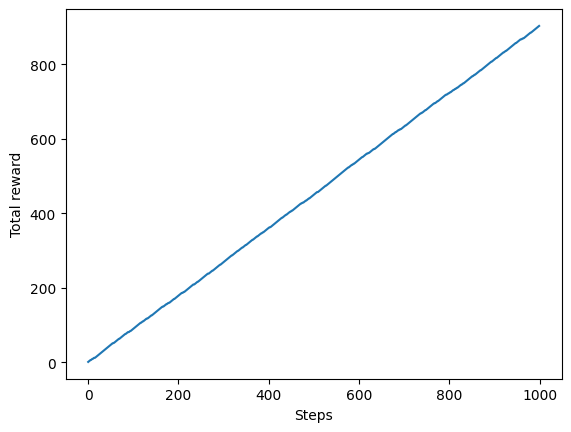

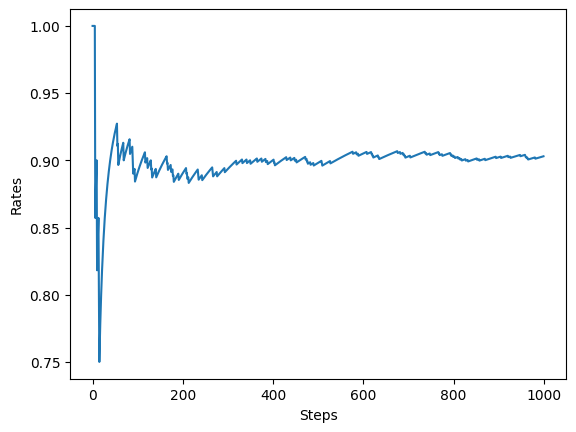

In [98]:
# グラフの描画(1)
plt.ylabel('Total reward')
plt.xlabel('Steps')
plt.plot(total_rewards)
plt.show()

# グラフの描画(2)
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

In [111]:
# ランダム性を考慮して平均的な良さを評価する
runs = 200 #1000回プレイを200回する
steps = 1000 
epsilon = 0.1
all_rates = np.zeros((runs, steps))

for run in range(runs):
    bandit = Bandit()
    agent = Agent(epsilon)

    total_reward = 0
    # total_rewards = []
    rate = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        total_reward += reward
        rate = total_reward/(step+1)

        # 描画用
        # total_rewards.append(total_reward)
        rates.append(rate)

    all_rates[run] = rates

avg_rates = np.average(all_rates, axis=0)

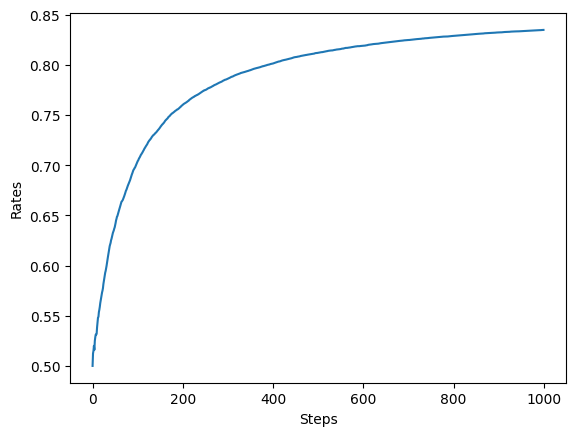

In [112]:
# グラフの描画(3)
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show()

In [110]:
# 非定常問題のバンディット
'''
10個のマシン
返すコインの枚数が1,0
各マシンの勝つ確率が変動する（ノイズ）
'''
class NonStatBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms) #マシンの勝率(1*10の配列

    def play(self, arm):
        rate = self.rates[arm]
        self.rates += 0.1*np.random.randn(self.arms) # ノイズを追加
        if rate > np.random.rand(): #試行の再現
            return 1
        else:
            return 0

In [114]:
class AlphaAgent:
    def __init__(self, epsilon, alpha, action_size=10): # action_size = マシンの数
        self.epsilon = epsilon
        self.alpha = alpha
        self.Qs = np.zeros(action_size)

    def update(self, action, reward):
        self.Qs[action] += (reward-self.Qs[action])*self.alpha

    def get_action(self):
        if self.epsilon > np.random.rand(): # 探索
            return np.random.randint(0, len(self.Qs)) # 違うマシンを選ぶ
        else: # 活用
            return np.argmax(self.Qs) # 報酬が一番大きいマシンを選ぶ

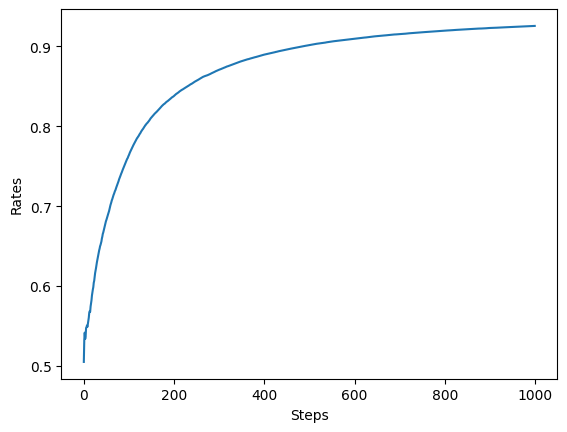

In [115]:
# ランダム性を考慮して平均的な良さを評価する
runs = 200 #1000回プレイを200回する
steps = 1000 
epsilon = 0.1
alpha = 0.8
all_rates = np.zeros((runs, steps))

for run in range(runs):
    bandit = NonStatBandit()
    agent = AlphaAgent(alpha=alpha, epsilon=epsilon)

    total_reward = 0
    # total_rewards = []
    rate = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        total_reward += reward
        rate = total_reward/(step+1)

        # 描画用
        # total_rewards.append(total_reward)
        rates.append(rate)

    all_rates[run] = rates

avg_rates = np.average(all_rates, axis=0)
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show()